# QUBO: The Ising Model

## MITP

The Ising spin model can be used to closely simulate the mathematical structure of Quadratic Unconstrained Binary Optimization (QUBO) problems, which are prolific in quantum computing, specifically adiabatic quantum computing. The optimization landscape of the Ising model is non-convex, which can make finding global minima challenging. Quantum Annealers can be used to combat this challenge, and can find the low energy state of the Ising model.

Here we will construct the simple example of the three qubit Ising model, which has a Hamiltonian of the form 

$$
H = - \sum_{\langle i j \rangle} J_{ij} \sigma_i \sigma_j,
$$

in the absence of external fields. Each spin can be $+1$ or $-1$ and $J_{ij}$ are the nearest-neighbour coupling strengths.

For simplicity, the first spin can be assumed to be in the “up” state (+1 eigenstate of Pauli-Z operator) and the coupling matrix can be set to $J=[-1, 1]$. The rotation angles for the other two spins are then optimized so that the energy of the system is minimized for the given couplings.

**Here we will use PyTorch. Please make sure to pip install the `requirements.txt`.**

In [7]:
import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np

import matplotlib
import matplotlib.pyplot as plt

## Setting up the circuit

We construct the three qubit system to represent three spins, with the first qubit in the “up” state.

In [2]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="torch")
def circuit(p1, p2):
    # We use the general Rot(phi,theta,omega,wires) single-qubit operation
    qml.Rot(p1[0], p1[1], p1[2], wires=1)
    qml.Rot(p2[0], p2[1], p2[2], wires=2)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

Here, the cost function to be minimized is defined as the energy of the spin configuration, emulating the quantum annealer system.

In [3]:
def cost(var1, var2):
    # the circuit function returns a numpy array of Pauli-Z expectation values
    spins = circuit(var1, var2)

    # the expectation value of Pauli-Z is +1 for spin up and -1 for spin down
    energy = -(1 * spins[0] * spins[1]) - (-1 * spins[1] * spins[2])
    return energy

## Exercise

Test the system for a known state, e.g. the [$s_1$, $s_2$, $s_3$] = [1, -1, -1] spin configuration.

In [4]:
### Your code here

## Optimisation

Here we very simply initialise the system using some random angles for the second and third qubit. 

In [5]:
torch.manual_seed(56)
p1 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)
p2 = Variable((np.pi * torch.rand(3, dtype=torch.float64)), requires_grad=True)

var_init = [p1, p2]
cost_init = cost(p1, p2)

We can now use PyTorch to optimise the cost function to find the minimum of the spin model.

In [6]:
opt = torch.optim.SGD(var_init, lr=0.1)

def closure():
    opt.zero_grad()
    loss = cost(p1, p2)
    loss.backward()
    return loss

var_pt = [var_init]
cost_pt = [cost_init]
x = [0]

for i in range(100):
    opt.step(closure)
    if (i + 1) % 5 == 0:
        x.append(i)
        p1n, p2n = opt.param_groups[0]["params"]
        costn = cost(p1n, p2n)
        var_pt.append([p1n, p2n])
        cost_pt.append(costn)

        # for clarity, the angles are printed as numpy arrays
        print("Energy after step {:5d}: {: .7f} | Angles: {}".format(
            i+1, costn, [p1n.detach().numpy(), p2n.detach().numpy()]),"\n"
        )

Energy after step     5:  0.6846474 | Angles: [array([1.96323939, 1.93604492, 2.32767565]), array([0.65212549, 2.73080219, 2.4299563 ])] 

Energy after step    10: -1.0138530 | Angles: [array([1.96323939, 1.0136468 , 2.32767565]), array([0.65212549, 2.73225282, 2.4299563 ])] 

Energy after step    15: -1.8171995 | Angles: [array([1.96323939, 0.38483073, 2.32767565]), array([0.65212549, 2.85992571, 2.4299563 ])] 

Energy after step    20: -1.9686584 | Angles: [array([1.96323939, 0.13026452, 2.32767565]), array([0.65212549, 2.97097572, 2.4299563 ])] 

Energy after step    25: -1.9930403 | Angles: [array([1.96323939, 0.04302756, 2.32767565]), array([0.65212549, 3.04042222, 2.4299563 ])] 

Energy after step    30: -1.9980133 | Angles: [array([1.96323939, 0.01413292, 2.32767565]), array([0.65212549, 3.08179844, 2.4299563 ])] 

Energy after step    35: -1.9993550 | Angles: [array([1.96323939, 0.00463472, 2.32767565]), array([0.65212549, 3.10627578, 2.4299563 ])] 

Energy after step    40: -1

We see that the minimum state is the -2 spin configuration corresponding to [$s_1$, $s_2$, $s_3$] = [1,1,-1], which corresponds to $(\phi, \theta, \omega) = (0,0,0)$ for the second spin, $s_2$, and the $(\phi, \theta, \omega) = (0,\pi,0)$ for the third spin, $s_3$.

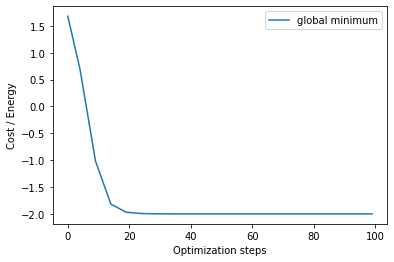

In [8]:
fig = plt.figure(figsize=(6, 4))

# Enable processing the Torch trainable tensors
with torch.no_grad():
    plt.plot(x, cost_pt, label = 'global minimum')
    plt.xlabel("Optimization steps")
    plt.ylabel("Cost / Energy")
    plt.legend()
    plt.show()

## Exercise:

Due to the complexity of the Ising spin model's optimisation space, it is easy to find local minima. Try using different initial conditions and check the model's ability to find the Global minimum.

In [ ]:
### Your code here